In [1]:
# + проверить выкидывание групп
# + сначала разбить, потом обработать
# + catboost

# neuron

# reg 2 classification


import gc

gc.enable()

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt  

from sklearn import preprocessing
from sklearn.model_selection import train_test_split


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import explained_variance_score

import lightgbm as lgb

import os
import os.path
# print(os.listdir("../input"))

# credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    return df

/usr/local/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
by_team = ['matchId','groupId']

In [3]:
random_seed = 15305
df_train = None

if not os.path.isfile('train_V2_solo.csv'):
    print('Solo file not exists, load all')
    df_train = pd.read_csv('train_V2.csv')
    df_train = reduce_mem_usage(df_train)
    df_train = df_train[df_train['winPlacePerc'].isna() != True]
    mapper = lambda x: 'solo' if ('solo' in x) else 'duo' if ('duo' in x) or ('crash' in x) else 'squad'
    
#     df_train['matchType'].value_counts().plot.bar()
    
    df_train['matchType'] = df_train['matchType'].apply(mapper)
    
    old_size = df_train.shape[0]
    
    df_train = df_train[df_train['matchType'] == 'solo']
    
    print('Reduced size from ', old_size, ' to ', df_train.shape[0])
    
    df_train.to_csv('train_V2_solo.csv', index=False)
    
else:
    df_train = pd.read_csv('train_V2_solo.csv')
    df_train = reduce_mem_usage(df_train)
    print('Solo file exists, loaded, size: ', df_train.shape[0])
        

gc.collect()

Solo file exists, loaded, size:  720712


7

In [4]:
df_train.describe(include=np.number).drop('count').T

,mean,std,min,25%,50%,75%,max
assists,0.062236,0.297540,0.0,0.000000,0.000000,0.000000,22.0
boosts,1.059862,1.799456,0.0,0.000000,0.000000,2.000000,28.0
damageDealt,NaN,NaN,0.0,0.000000,74.375000,169.250000,6616.0
DBNOs,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
headshotKills,0.249281,0.660425,0.0,0.000000,0.000000,0.000000,42.0
heals,1.014149,2.406086,0.0,0.000000,0.000000,1.000000,63.0
killPlace,47.457529,27.728956,1.0,23.000000,47.000000,71.000000,100.0
killPoints,447.426431,594.989089,0.0,0.000000,0.000000,1090.000000,1970.0
kills,0.936860,1.603249,0.0,0.000000,0.000000,1.000000,66.0
killStreaks,0.475054,0.564241,0.0,0.000000,0.000000,1.000000,18.0


In [5]:
# none of null, inf columns
null_columns=df_train.columns[df_train.isin([np.Inf, np.NINF, np.nan]).any()]
df_train[null_columns].isnull().sum()

Series([], dtype: float64)

In [6]:
df_train.drop('DBNOs',  axis =1,inplace= True)
df_train.drop('revives',  axis =1,inplace= True)

In [7]:
df_train['maxPlace'].describe()

count    720712.000000
mean         93.908900
std          10.134818
min           2.000000
25%          94.000000
50%          96.000000
75%          97.000000
max         100.000000
Name: maxPlace, dtype: float64

In [8]:

def feature_engineering(df, is_train=True):
    test_idx = None
    if not is_train: 
        print("processing test")
        test_idx = df.Id
    else:
        print("processing train")
#         Попробовал, точность упала, не нравится // model_train_out_group_size.txt
#         отвергнуто 
# 
#         print('Len before deleting ', df.shape[0])
#         agg = df.groupby(by_team).size().reset_index(name='group_size')
#         print('Group size > 1:', agg[agg['group_size'] > 1].shape[0])
#         df = df.merge(agg, how='left', on=by_team)
#         df = df[df['group_size'] <= 1]
    
#         df.drop('group_size',  axis =1,inplace= True)
        
#         print('Len after deleting ', df.shape[0])
    

    
    print("remove some columns")
    target = 'winPlacePerc'

    print("Adding Features")
    
#     Гиптеза о +1 при делении ухудшила результат lightgbm, у catboost незначительное улучшение
#    отвергнуто
# 
    
    df['headshotrate'] = df['kills']/ (df['headshotKills'] )
    df['killStreakrate'] = df['killStreaks']/ (df['kills'] )
    df['healthitems'] = df['heals'] + df['boosts']
    df['totalDistance'] = df['rideDistance'] + df["walkDistance"] + df["swimDistance"]
    df['killPlace_over_maxPlace'] = df['killPlace'] / (df['maxPlace'] )
    
    df['distance_over_weapons'] = df['totalDistance'] / (df['weaponsAcquired'] )
    df['walkDistance_over_heals'] = df['walkDistance'] / (df['heals'] )
    df['walkDistance_over_kills'] = df['walkDistance'] / (df['kills'] )
    df['killsPerWalkDistance'] = df['kills'] / (df['walkDistance'] )
    
    
    df['totalTimeByDistance'] = df['rideDistance'] / float(5) + df['walkDistance'] + df['swimDistance'] * float(5)

#     not play role
#     df['zombi'] = ((df['totalDistance'] == 0) & (df['kills'] == 0)
#                      & (df['weaponsAcquired'] == 0)).astype(int)
#     df['cheater'] = ((df['kills'] / df['totalDistance'] >= 1)
#                        | (df['kills'] > 30) | (df['roadKills'] > 10)).astype(int)
#     df['headshotKills_over_kills'] = df['headshotKills'] / (df['kills'] )

#     df['skill'] = df['headshotKills'] + df['roadKills']

    df[df == np.Inf] = np.NaN
    df[df == np.NINF] = np.NaN
    
    print("Removing Na's From DF")
    df.fillna(0, inplace=True)

    
    features = list(df.columns)
    features.remove("Id")

    features.remove(target)
    features.remove("matchId")
    
    features.remove("groupId")
    features.remove("matchType")
    
    features.remove('roadKills')
    
    features.remove('teamKills')
    
    features.remove('killStreaks')
    
    features.remove('kills')
    
    features.remove('vehicleDestroys')
    
    features.remove('headshotKills')
    
    features.remove('assists')
    
    features.remove('swimDistance')
    
    
    
    return df[features], df[target], features, test_idx
    

In [9]:
# X, y, columns, _ = feature_engineering(df_train, True)
# X = reduce_mem_usage(X)

In [10]:
import random

# ухудшает, потому что этим надо разбивать изначально,а не только обучение

def train_test_split_match(df, test_size=0.1):
    match_ids = df['matchId'].unique().tolist()
    train_size = int(len(match_ids) * (1 - test_size))
    train_match_ids = random.sample(match_ids, train_size)

    train = df[df['matchId'].isin(train_match_ids)]
    test = df[-df['matchId'].isin(train_match_ids)]
    
    train_y = train['winPlacePerc']
    test_y = test['winPlacePerc']
    
    train.drop(['matchId','winPlacePerc'] ,  axis =1,inplace= True)
    test.drop(['matchId','winPlacePerc'] ,  axis =1,inplace= True)
    
    return train, test, train_y, test_y

In [11]:
# X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.1,
# random_state=random_seed)

import warnings
warnings.filterwarnings("ignore")

X_train, X_holdout, y_train, y_holdout = train_test_split(df_train, df_train['winPlacePerc'], test_size=0.1,
random_state=random_seed)


X_train, y_train, columns, _ = feature_engineering(X_train, True)
X_train = reduce_mem_usage(X_train)


X_holdout, _, _ ,_ = feature_engineering(X_holdout, False)

train_index = round(int(X_train.shape[0]*0.9))
dev_X = X_train[:train_index] 
val_X = X_train[train_index:]
dev_y = y_train[:train_index] 
val_y = y_train[train_index:] 
gc.collect()

gc.collect()
print(dev_X.shape, val_X.shape)

processing train
remove some columns
Adding Features
Removing Na's From DF
processing test
remove some columns
Adding Features
Removing Na's From DF
(583776, 24) (64864, 24)


In [12]:
print(X_train.shape, X_holdout.shape)

(648640, 24) (72072, 24)


In [13]:



model_name = '0.9_3000_model_best.txt'

def run_lgb(train_X, train_y, val_X, val_y, x_test):
    params = {"objective" : "regression", "metric" : "mae", 'n_estimators':30000,#20000,
              'early_stopping_rounds':300,
              "num_leaves" : 31, "learning_rate" : 0.05, 
              "bagging_fraction" : 0.9,#0.7,
               "bagging_seed" : 0, "num_threads" : 4,"colsample_bytree" : 0.9#0.7
             }
    model = None
    
    if not os.path.isfile(model_name):
        print(model_name, ' not found, start train ;-(')
        lgtrain = lgb.Dataset(train_X, label=train_y)
        lgval = lgb.Dataset(val_X, label=val_y)
        model = lgb.train(params, lgtrain, valid_sets=[lgtrain, lgval], verbose_eval=1000)
        model.save_model(model_name)
        
    else:
        print(model_name, ' found, start predict ;-)')
        model = lgb.Booster(model_file=model_name)
        
    
    pred_test_y = model.predict(x_test, num_iteration=model.best_iteration)
    return pred_test_y, model

# Training the model #
pred_test, model = run_lgb(dev_X, dev_y, val_X, val_y, X_holdout)
gc.collect()

0.9_3000_model_best.txt  not found, start train ;-(
Training until validation scores don't improve for 300 rounds.
[1000]	training's l1: 0.039359	valid_1's l1: 0.0401486
[2000]	training's l1: 0.0380505	valid_1's l1: 0.0396147
[3000]	training's l1: 0.0370963	valid_1's l1: 0.0393778
[4000]	training's l1: 0.0362851	valid_1's l1: 0.0392118
[5000]	training's l1: 0.0355175	valid_1's l1: 0.0390737
[6000]	training's l1: 0.0348238	valid_1's l1: 0.0389689
[7000]	training's l1: 0.0341305	valid_1's l1: 0.0388526
[8000]	training's l1: 0.0334965	valid_1's l1: 0.0387643
[9000]	training's l1: 0.0328906	valid_1's l1: 0.0386679
[10000]	training's l1: 0.0322927	valid_1's l1: 0.0385567
[11000]	training's l1: 0.0317533	valid_1's l1: 0.0385095
[12000]	training's l1: 0.031213	valid_1's l1: 0.0384399
[13000]	training's l1: 0.0307228	valid_1's l1: 0.0384164
[14000]	training's l1: 0.0302417	valid_1's l1: 0.0383853
[15000]	training's l1: 0.0297556	valid_1's l1: 0.038332
[16000]	training's l1: 0.0292938	valid_1's

7

In [14]:
pred_y = pred_test.copy()
df_sub = X_holdout.copy()
gc.collect()
df_sub.head()

,boosts,damageDealt,heals,killPlace,killPoints,longestKill,matchDuration,maxPlace,numGroups,rankPoints,...,headshotrate,killStreakrate,healthitems,totalDistance,killPlace_over_maxPlace,distance_over_weapons,walkDistance_over_heals,walkDistance_over_kills,killsPerWalkDistance,totalTimeByDistance
252538,0,0.00,0,96,1670,0.00000,1457,96,92,-1,...,0.0,0.0,0,0.0,1.000000,0.000,0.0,0.0,0.000000,0.0
443955,0,0.00,4,57,0,0.00000,599,54,27,1500,...,0.0,0.0,4,0.0,1.055556,0.000,0.0,0.0,0.000000,0.0
134536,1,0.00,0,58,0,0.00000,1841,96,95,1517,...,0.0,0.0,1,2156.0,0.604167,308.000,0.0,0.0,0.000000,1088.0
663320,5,205.75,3,13,0,304.25000,1852,97,94,1484,...,0.0,0.5,8,4440.0,0.134021,888.000,1480.0,2220.0,0.000450,4440.0
56745,0,100.00,0,33,0,5.84375,1959,93,89,1491,...,0.0,1.0,0,329.5,0.354839,82.375,0.0,329.5,0.003035,329.5


In [15]:
print("MAE: ",
mean_absolute_error(y_holdout, pred_y) )

print("MSE: ",
mean_squared_error(y_holdout, pred_y))

MAE:  0.03830846598148164
MSE:  0.003364273722618492


MAE:  0.038204562611468304
MSE:  0.0033404532355836075

MAE:  0.03835205551321234
MSE:  0.0033308355521584616

MAE:  0.039442003815586504<br>
MSE:  0.0034430096325873847<br>
<br>

MAE:  0.04354560510495446<br>
MSE:  0.00416523884441271<br>
<br>
MAE:  0.3085248959709384 <br>
MSE:  0.1272983096471534

In [21]:
def fix_pred(X, pred):
    df_sub = X.copy()
    df_sub['winPlacePerc'] = pred
    df_sub.loc[df_sub.maxPlace == 0, "winPlacePerc"] = 0
    df_sub.loc[df_sub.maxPlace == 1, "winPlacePerc"] = 1.0
    df_sub.loc[(df_sub['maxPlace'] > 1) & (df_sub['numGroups'] == 1), 'winPlacePerc'] = 0
    subset = df_sub.loc[df_sub.maxPlace > 1]
    gap = 1.0 / (subset.maxPlace.values - 1)
    new_perc = np.around(subset.winPlacePerc.values / gap) * gap
    df_sub.loc[df_sub.maxPlace > 1, "winPlacePerc"] = new_perc
    
#     df_sub.loc[df_sub["winPlacePerc"] < 0, "winPlacePerc"] = 0
#     df_sub.loc[df_sub["winPlacePerc"] > 1, "winPlacePerc"] = 1.0
    
    
    return df_sub["winPlacePerc"]

light_fix_pred = fix_pred(df_sub, pred_test)

print("MAE: ",
mean_absolute_error(y_holdout, light_fix_pred) )

print("MSE: ",
mean_squared_error(y_holdout, light_fix_pred))

MAE:  0.038083923831013285
MSE:  0.0033619125949910264


MAE:  0.03794351563520207
MSE:  0.003343428900863441

In [17]:
fi = model.feature_importance(importance_type='gain')
fn = model.feature_name()
fi = fi / fi.max() * 100

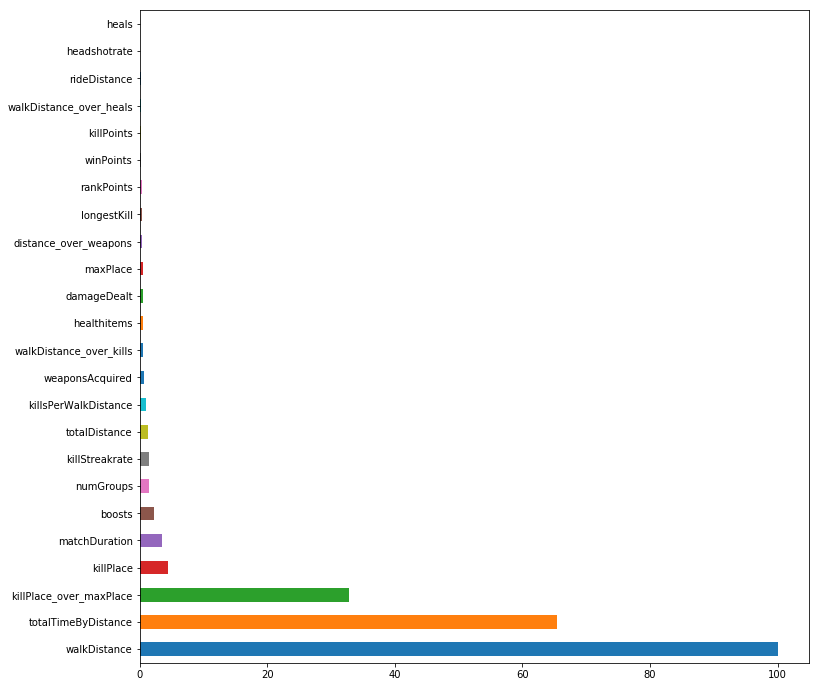

In [18]:
feat_importances = pd.Series(fi, index=fn)
feat_importances.nlargest(30).plot(kind='barh', figsize=(12,12))

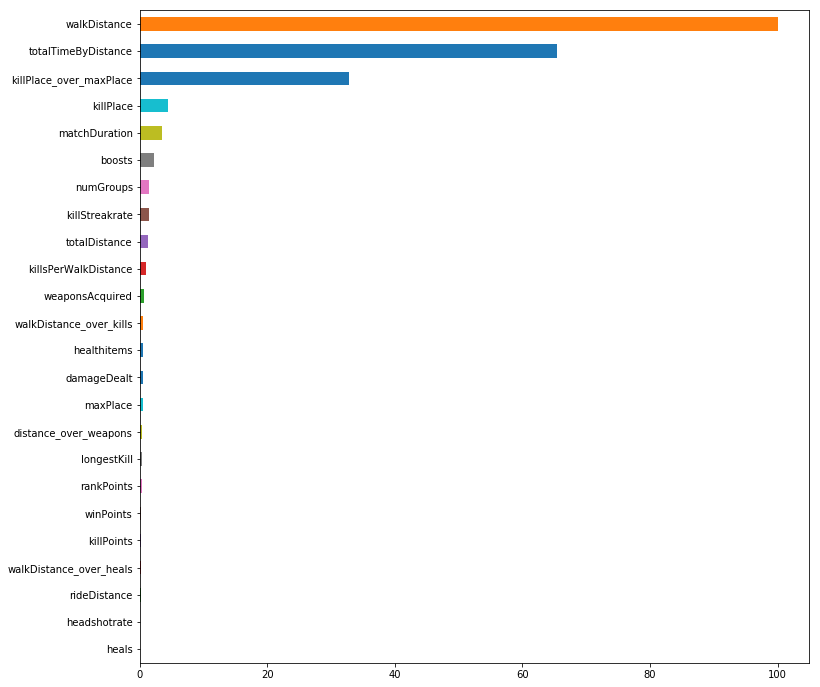

In [19]:
feat_importances.nsmallest(30).plot(kind='barh', figsize=(12,12))

# Test CatBoost

In [27]:
import catboost
from catboost import CatBoostRegressor

cat_model_name = 'new_cat_model.txt'
def run_catboost(X_train, y_train, X_val, y_val, X_test):
    model = None
    
    
    
    if not os.path.isfile(cat_model_name):
        print(cat_model_name, ' not found, start train ;-(')
        model = CatBoostRegressor(iterations=2500,#1500,
                             learning_rate=0.05,
                             depth=13,
                             eval_metric='MAE',
                              
                             bootstrap_type='Bayesian',
                             bagging_temperature = 0.4,
                             colsample_bylevel=0.9,

                             od_type='Iter',

                             od_wait=20)
        model.fit(X_train, y_train,
              eval_set=(X_val, y_val),
              use_best_model=True,
              verbose=False)
        model.save_model(cat_model_name)
        
    else:
        print(cat_model_name, ' found, start predict ;-)')
        model = CatBoostRegressor()
        model.load_model(cat_model_name)
    
    
    
    
    y_pred_submit = model.predict(X_test)

    return y_pred_submit, model

In [28]:
cat_preds, cat_model = run_catboost(dev_X, dev_y, val_X, val_y, X_holdout)
gc.collect()


new_cat_model.txt  not found, start train ;-(


7

In [29]:
print("MAE: ",
mean_absolute_error(y_holdout, cat_preds) )

print("MSE: ",
mean_squared_error(y_holdout, cat_preds))

print("MAE: ",
mean_absolute_error(y_holdout, fix_pred(df_sub,cat_preds)) )

MAE:  0.03948523558386459
MSE:  0.003474875717002028
MAE:  0.03926446539568229


In [ ]:
MAE:  0.03930947714587424
MSE:  0.003449869912570009
    
MAE:  0.03935530079373704
MSE:  0.003452247054532898
    
MAE:  0.03937937994147074
MSE:  0.003442165049903201
    
MAE:  0.03985730187929903
MSE:  0.0035289553600514898
    
MAE:  0.039967249401811435
MSE:  0.0035292414797628764
    
MAE:  0.040002110668519705
MSE:  0.0035109118428077045
    
MAE:  0.04018625081067348
MSE:  0.0035448821657998275

In [64]:
cat_fi = cat_model.get_feature_importance(fstr_type='FeatureImportance')
cat_fn = cat_model.feature_names_
cat_fi = cat_fi


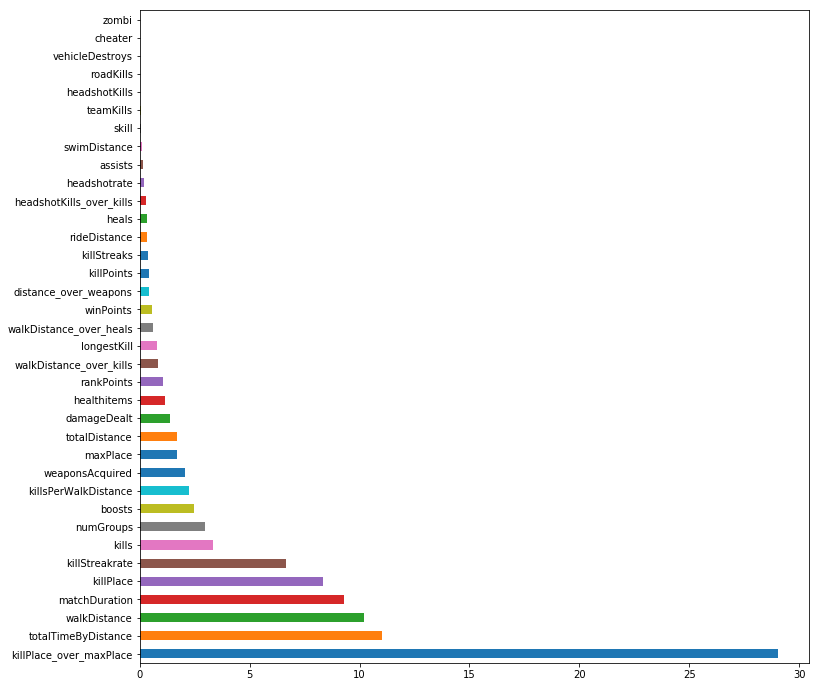

In [65]:
cat_feat_importances = pd.Series(cat_fi, index=cat_fn)
cat_feat_importances.nlargest(50).plot(kind='barh', figsize=(12,12))

# Random forest
<!--https://www.kaggle.com/pavelvpster/pubg-random-forest-baseline !-->

In [30]:
from sklearn.ensemble import RandomForestRegressor
# X_train, X_holdout, y_train, y_holdout 
rf = RandomForestRegressor(n_estimators=3000, criterion='mse',max_depth=6,
                           min_samples_leaf=3, max_features='sqrt',
                           n_jobs=-1, verbose=True)
rf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   43.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 10.9min finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=6,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=3, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=3000, n_jobs=-1,
           oob_score=False, random_state=None, verbose=True,
           warm_start=False)

In [31]:
rf_y_pred = rf.predict(X_holdout)

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:    2.4s
[Parallel(n_jobs=4)]: Done 2442 tasks      | elapsed:    3.3s
[Parallel(n_jobs=4)]: Done 3000 out of 3000 | elapsed:    3.9s finished


In [32]:
print("MAE: ",
mean_absolute_error(y_holdout, rf_y_pred) )

print("MSE: ",
mean_squared_error(y_holdout, rf_y_pred))

MAE:  0.06152973927288206
MSE:  0.00752133078270472


MAE:  0.06138763809018693 <br>
MSE:  0.007488019050449579 <br>
неплохо, но lightgbm лучше

In [66]:
rf_fi = rf.feature_importances_
rf_fn = X_train.columns

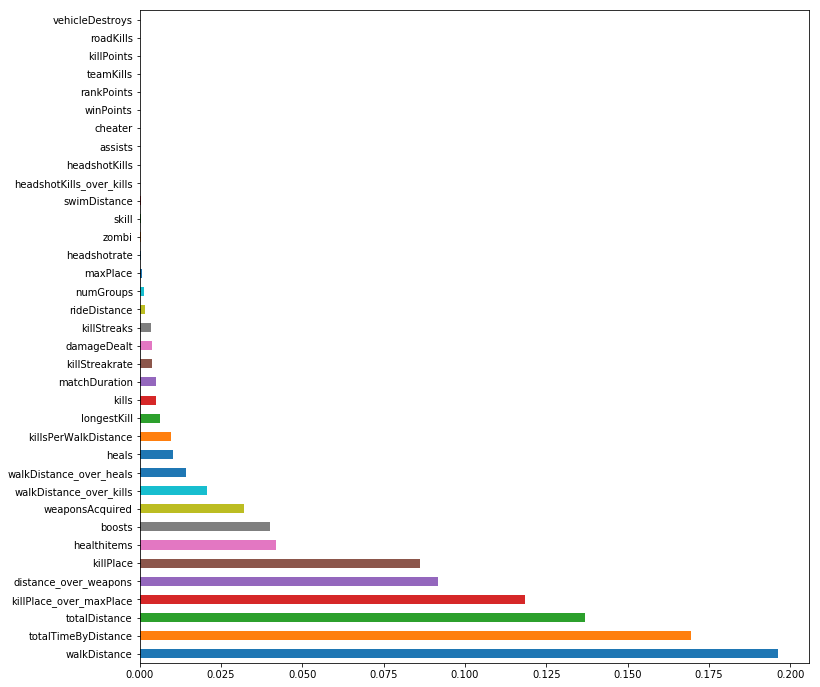

In [154]:
rf_feat_importances = pd.Series(rf_fi, index=rf_fn)
rf_feat_importances.nlargest(50).plot(kind='barh', figsize=(12,12))

# xgboost

In [22]:
import xgboost

In [23]:
xgb = xgboost.XGBRegressor(
    n_estimators=1650, max_depth=11,
    disable_default_eval_metric=1,
    
    subsample=0.9,
    colsample_bytree=0.9,
    learning_rate=0.05#0.007
    )
xgb.fit(dev_X, dev_y,
        eval_set=[(val_X, val_y)], eval_metric='mae',
        early_stopping_rounds=100)

[0]	validation_0-mae:0.246323
Will train until validation_0-mae hasn't improved in 100 rounds.
[1]	validation_0-mae:0.234552
[2]	validation_0-mae:0.223397
[3]	validation_0-mae:0.212828
[4]	validation_0-mae:0.202803
[5]	validation_0-mae:0.193305
[6]	validation_0-mae:0.184309
[7]	validation_0-mae:0.175794
[8]	validation_0-mae:0.167706
[9]	validation_0-mae:0.160162
[10]	validation_0-mae:0.152954
[11]	validation_0-mae:0.146123
[12]	validation_0-mae:0.139673
[13]	validation_0-mae:0.133583
[14]	validation_0-mae:0.127836
[15]	validation_0-mae:0.122413
[16]	validation_0-mae:0.117289
[17]	validation_0-mae:0.112464
[18]	validation_0-mae:0.107933
[19]	validation_0-mae:0.103652
[20]	validation_0-mae:0.099629
[21]	validation_0-mae:0.095887
[22]	validation_0-mae:0.092326
[23]	validation_0-mae:0.088999
[24]	validation_0-mae:0.085866
[25]	validation_0-mae:0.082929
[26]	validation_0-mae:0.08018
[27]	validation_0-mae:0.077598
[28]	validation_0-mae:0.075204
[29]	validation_0-mae:0.072928
[30]	validation_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9, disable_default_eval_metric=1, gamma=0,
       learning_rate=0.05, max_delta_step=0, max_depth=11,
       min_child_weight=1, missing=None, n_estimators=1650, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.9)

In [24]:
xgb_y_pred = xgb.predict(X_holdout)

In [25]:
print("MAE: ",
mean_absolute_error(y_holdout, xgb_y_pred) )

print("MSE: ",
mean_squared_error(y_holdout, xgb_y_pred))


print("MAE: ",
mean_absolute_error(y_holdout, fix_pred(df_sub, xgb_y_pred)) )

MAE:  0.038013875
MSE:  0.0033959874
MAE:  0.03778602075403553


In [99]:
MAE:  0.03787041
MSE:  0.0033754273
MAE:  0.037610762662964786
    
MAE:  0.03984858
MSE:  0.0035125967
MAE:  0.03963832653640412

In [99]:
# from sklearn.model_selection import GridSearchCV

In [102]:
# params_grid_xgb = {
#           'reg_alpha': [0, 0.5],
#           'reg_lambda': [0, 0.5],
#           'gamma': [0, 0.5],
#           'subsample': [0.7, 1],
#           'colsample_bytree':[0.7, 1],
#           'max_depth': [1] +[1 + i*2 for i in range(3,6)],
#           'learning_rate': [0.05],
#           'n_estimators': [1000 + 500*i for i in range(1,3)]
# }
# xgb_grid = GridSearchCV(xgb, param_grid=params_grid_xgb, cv=5, n_jobs=-1,
# verbose=True)
# print(params_grid_xgb)

{'reg_alpha': [0, 0.5], 'reg_lambda': [0, 0.5], 'gamma': [0, 0.5], 'subsample': [0.7, 1], 'colsample_bytree': [0.7, 1], 'max_depth': [1, 7, 9, 11], 'learning_rate': [0.05], 'n_estimators': [1500, 2000]}


In [ ]:
# xgb_grid.fit(X_train, y_train)
# print("Fit end")
# print(xgb_grid.best_params_, xgb_grid.best_score_)

In [115]:
xgb.save_model('xgb_037')

MAE:  0.03984858 <br>
MSE:  0.0035125967 <br>
на уровне с lightgbm

In [155]:
xgb_fi = xgb.feature_importances_
xgb_fn = X_train.columns

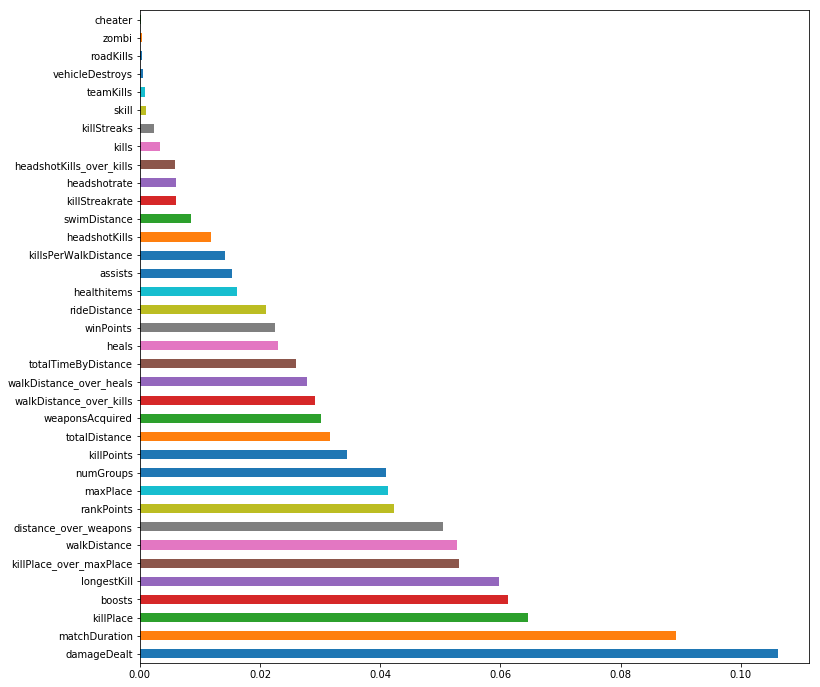

In [156]:
xgb_feat_importances = pd.Series(xgb_fi, index=xgb_fn)
xgb_feat_importances.nlargest(50).plot(kind='barh', figsize=(12,12))

In [157]:
xgb_cat_light = (xgb_y_pred + cat_preds + pred_y) / float(3)
print("MAE: ",
mean_absolute_error(y_holdout, xgb_cat_light) )

print("MSE: ",
mean_squared_error(y_holdout, xgb_cat_light))

MAE:  0.03797528697856334
MSE:  0.0032927908276403914


In [158]:
xgb_cat_light_rf = (0.1*xgb_y_pred + 0.05*cat_preds + 0.8*pred_y + 0.05*rf_y_pred) 
xgb_cat_light_rf = fix_pred(df_sub, xgb_cat_light_rf)
print("MAE: ",
mean_absolute_error(y_holdout, xgb_cat_light_rf) )

print("MSE: ",
mean_squared_error(y_holdout, xgb_cat_light_rf))



MAE:  0.03797135476325532
MSE:  0.0033159750784003505


In [34]:
import itertools
all_pred = [fix_pred(df_sub, xgb_y_pred) , fix_pred(df_sub, cat_preds) ,
            fix_pred(df_sub,pred_y), fix_pred(df_sub,rf_y_pred)]

all_names = ['xgb', 'cat', 'light', 'rf']

perms = [x for l in range(1, len(all_pred)) for x in itertools.combinations(all_pred, l)]

perms_names = [x for l in range(1, len(all_names)) for x in itertools.combinations(all_names, l)]

best_mae = 99
best_comb = ''
for p, p_name in zip(perms, perms_names):
    pred = sum(p) / len(p)
    
    pred = fix_pred(df_sub,pred)
    
    pred[pred > 1] = 1.0
    pred[pred < 0] = 0.0
    
    mae = mean_absolute_error(y_holdout, pred)
    print("MAE: ",
     mae)
    if mae < best_mae:
        best_mae = mae
        best_comb = p_name
        

    print("MSE: ",
    mean_squared_error(y_holdout, pred))
    print('next')
    
print("Best MAE: ",
     best_mae)
print(best_comb)

MAE:  0.037746369479495535
MSE:  0.003386922487050065
next
MAE:  0.03920872519577114
MSE:  0.0034727321905192736
next
MAE:  0.03798333586719171
MSE:  0.0033494859993603594
next
MAE:  0.06116838241632001
MSE:  0.0074798225768696125
next
MAE:  0.038191402994205675
MSE:  0.003368278393564833
next
MAE:  0.03759424506121209
MSE:  0.0033155762354472747
next
MAE:  0.04599723555035254
MSE:  0.004412162401599476
next
MAE:  0.03827610748220132
MSE:  0.003350663992219019
next
MAE:  0.04673164083684804
MSE:  0.004508077871945318
next
MAE:  0.045899535450731346
MSE:  0.004371186003457268
next
MAE:  0.03784988756186855
MSE:  0.003314915299128168
next
MAE:  0.042573128774908625
MSE:  0.003858604149633858
next
MAE:  0.04203062973567249
MSE:  0.003787345678589455
next
MAE:  0.04254408112013341
MSE:  0.003839202144535005
next
Best MAE:  0.03759424506121209
('xgb', 'light')


In [36]:
xgb_cat_light_rf = (0.54*fix_pred(df_sub,xgb_y_pred) +  0.46*fix_pred(df_sub,pred_y)) 
xgb_cat_light_rf = fix_pred(df_sub, xgb_cat_light_rf)

xgb_cat_light_rf[xgb_cat_light_rf > 1] = 1.0
xgb_cat_light_rf[xgb_cat_light_rf < 0] = 0.0

print("MAE: ",
mean_absolute_error(y_holdout, xgb_cat_light_rf) )

print("MSE: ",
mean_squared_error(y_holdout, xgb_cat_light_rf))



MAE:  0.037496861101663614
MSE:  0.0033097444992060757


In [35]:
best = 1.0
best_mae = 11
for i in range(5400, 5600):
    part = 0.0001 * i
    pred = (part*fix_pred(df_sub,xgb_y_pred) +  (1 - part)*fix_pred(df_sub,pred_y)) 
    
    pred = fix_pred(df_sub,pred)
    
    pred[pred > 1] = 1.0
    pred[pred < 0] = 0.0
#     print(part)
    
    mae = mean_absolute_error(y_holdout, pred)
    if mae < best_mae:
        best_mae = mae
        best = part
print(best_mae, best)

0.037496861101663614 0.54
